In [1]:
# Step 1: Import necessary libraries
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [2]:
# Load the dataset and specify the sheet
data = pd.read_excel('Delivery truck trip data (2).xlsx', sheet_name='VTS Data 280820')

In [3]:
# Check and handle missing values
print("Null values in each column before handling:")
print(data.isnull().sum())

Null values in each column before handling:
GpsProvider                            953
BookingID                                0
Market/Regular                           0
BookingID_Date                           0
vehicle_no                               0
Origin_Location                          0
Destination_Location                     0
Org_lat_lon                              0
Des_lat_lon                              0
Data_Ping_time                         953
Planned_ETA                              0
Current_Location                       964
DestinationLocation                      0
actual_eta                              37
Curr_lat                               953
Curr_lon                               953
is_delayed                              14
ontime                                4332
delay                                 2538
OriginLocation_Code                      3
DestinationLocation_Code                27
trip_start_date                          0
trip_end_d

In [4]:
# Drop rows with NaN in 'actual_eta' and 'GpsProvider'
data = data.dropna(subset=['actual_eta', 'GpsProvider'])

In [5]:
# Drop unnecessary columns
data = data.drop(columns=['Driver_MobileNo','trip_start_date', 'trip_end_date', 'ontime', 'delay','BookingID', 'BookingID_Date', 'Data_Ping_time','is_delayed'], errors='ignore')


In [6]:
#Conversion to datetime format
data['Planned_ETA'] = pd.to_datetime(data['Planned_ETA'])
data['actual_eta'] = pd.to_datetime(data['actual_eta'])

# Converting to hours and minutes
data['Planned_ETA_hour'] = data['Planned_ETA'].dt.hour
data['Planned_ETA_minutes'] = data['Planned_ETA'].dt.minute

data['actual_eta_hour'] = data['actual_eta'].dt.hour
data['actual_eta_minutes'] = data['actual_eta'].dt.minute

In [7]:
# Handle coordinates - split lat and lon
for col in ['Org_lat_lon', 'Des_lat_lon']:
    if col in data.columns:
        data[f"{col}_lat"], data[f"{col}_lon"] = zip(*data[col].apply(lambda x: map(float, x.split(',')) if pd.notnull(x) else (np.nan, np.nan)))
        data.drop(columns=[col], inplace=True)  # Drop original column

In [8]:
# Encode categorical variables
categorical_cols = ['GpsProvider', 'Market/Regular', 'vehicle_no', 'Origin_Location', 'Destination_Location',
                    'Current_Location', 'DestinationLocation', 'Driver_Name', 'customerID', 'customerNameCode',
                    'supplierID', 'supplierNameCode', 'Material Shipped']
label_encoders = {}
for col in categorical_cols:
    if col in data.columns:
        le = LabelEncoder()
        data[col] = le.fit_transform(data[col].astype(str))
        label_encoders[col] = le


In [9]:
#  Handle missing values
# Categorical columns (fill with mode)
categorical_columns = ['OriginLocation_Code', 'DestinationLocation_Code', 'vehicleType', 'Driver_Name', 'Current_Location']
for col in categorical_columns:
    if data[col].isnull().sum() > 0:
        mode_value = data[col].mode()[0]
        data[col].fillna(mode_value, inplace=True)
        print(f"Filled missing values in '{col}' with mode: {mode_value}")

# Numeric columns (fill with mean or median)
numeric_columns = ['TRANSPORTATION_DISTANCE_IN_KM', 'Minimum_kms_to_be_covered_in_a_day']
for col in numeric_columns:
    if data[col].isnull().sum() > 0:
        mean_value = data[col].mean()
        data[col].fillna(mean_value, inplace=True)
        print(f"Filled missing values in '{col}' with mean: {mean_value}")

Filled missing values in 'OriginLocation_Code' with mode: V0048673 
Filled missing values in 'DestinationLocation_Code' with mode: CHEMMNFILCCA1
Filled missing values in 'vehicleType' with mode: 40 FT 3XL Trailer 35MT
Filled missing values in 'TRANSPORTATION_DISTANCE_IN_KM' with mean: 581.5604192139738
Filled missing values in 'Minimum_kms_to_be_covered_in_a_day' with mean: 248.8432122370937


<ipython-input-9-2e2b416fb7b0>:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[col].fillna(mode_value, inplace=True)
<ipython-input-9-2e2b416fb7b0>:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.m

In [10]:
#Check and handle missing values
print("Null values in each column before handling:")
print(data.isnull().sum())

Null values in each column before handling:
GpsProvider                           0
Market/Regular                        0
vehicle_no                            0
Origin_Location                       0
Destination_Location                  0
Planned_ETA                           0
Current_Location                      0
DestinationLocation                   0
actual_eta                            0
Curr_lat                              0
Curr_lon                              0
OriginLocation_Code                   0
DestinationLocation_Code              0
TRANSPORTATION_DISTANCE_IN_KM         0
vehicleType                           0
Minimum_kms_to_be_covered_in_a_day    0
Driver_Name                           0
customerID                            0
customerNameCode                      0
supplierID                            0
supplierNameCode                      0
Material Shipped                      0
Planned_ETA_hour                      0
Planned_ETA_minutes                 

In [11]:
# Confirm all features are numeric
print("\nData types after processing:")
print(data.dtypes)

# Verify if there are any non-numeric columns left
non_numeric_columns = data.select_dtypes(include=['object']).columns
if len(non_numeric_columns) > 0:
    print(f"Non-numeric columns still present: {list(non_numeric_columns)}")
else:
    print("All columns are now numeric.")


Data types after processing:
GpsProvider                                    int64
Market/Regular                                object
vehicle_no                                     int64
Origin_Location                                int64
Destination_Location                           int64
Planned_ETA                           datetime64[ns]
Current_Location                               int64
DestinationLocation                            int64
actual_eta                            datetime64[ns]
Curr_lat                                     float64
Curr_lon                                     float64
OriginLocation_Code                           object
DestinationLocation_Code                      object
TRANSPORTATION_DISTANCE_IN_KM                float64
vehicleType                                   object
Minimum_kms_to_be_covered_in_a_day           float64
Driver_Name                                    int64
customerID                                     int64
customerNameCode

In [12]:
#Clean column names to avoid issues with whitespace
data.columns = data.columns.str.strip()  # Remove any leading/trailing spaces

# Encode all categorical columns using Label Encoding
# Updated list of categorical columns
categorical_columns = ['Market/Regular','OriginLocation_Code','DestinationLocation_Code','vehicleType'
]

# Apply Label Encoding to all specified columns
label_encoders = {}
for col in categorical_columns:
    if col in data.columns:  # Check if the column exists in the dataset
        data[col] = data[col].astype(str)  # Convert to string to ensure compatibility
        le = LabelEncoder()
        data[col] = le.fit_transform(data[col])
        label_encoders[col] = le  # Store the encoder

# Confirm all features are numeric
print("\nData types after processing:")
print(data.dtypes)

# Verify if there are any non-numeric columns left
non_numeric_columns = data.select_dtypes(include=['object']).columns
if len(non_numeric_columns) > 0:
    print(f"Non-numeric columns still present: {list(non_numeric_columns)}")
else:
    print("All columns are now numeric.")



Data types after processing:
GpsProvider                                    int64
Market/Regular                                 int64
vehicle_no                                     int64
Origin_Location                                int64
Destination_Location                           int64
Planned_ETA                           datetime64[ns]
Current_Location                               int64
DestinationLocation                            int64
actual_eta                            datetime64[ns]
Curr_lat                                     float64
Curr_lon                                     float64
OriginLocation_Code                            int64
DestinationLocation_Code                       int64
TRANSPORTATION_DISTANCE_IN_KM                float64
vehicleType                                    int64
Minimum_kms_to_be_covered_in_a_day           float64
Driver_Name                                    int64
customerID                                     int64
customerNameCode

In [13]:
# Transform actual_eta_hour and actual_eta_minutes into a single target variable
# Convert hours and minutes into total minutes
X = data.drop(columns=['actual_eta', 'Planned_ETA', 'actual_eta_minutes','actual_eta_hour'], errors='ignore')  # Features
y = data[['actual_eta_minutes','actual_eta_hour']]
y['actual_eta_total_minutes'] = y['actual_eta_hour'] * 60 + y['actual_eta_minutes'] #target

# Update target variable and split data
X_train, X_test, y_train, y_test = train_test_split(X, y['actual_eta_total_minutes'], test_size=0.2, random_state=42)

# Step 3: Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 4: Define and Train the LightGBM Model
lgb_model = lgb.LGBMRegressor(
    max_depth=5,
    num_leaves=10,
    learning_rate=0.01,
    n_estimators=1000,
)

# Train the model
lgb_model.fit(X_train_scaled, y_train)

# Step 5: Make Predictions
y_train_pred = lgb_model.predict(X_train_scaled)
y_test_pred = lgb_model.predict(X_test_scaled)

# Step 6: Evaluate the Model using RMSE (in minutes)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

print(f"Train RMSE (Total Minutes): {train_rmse}")
print(f"Test RMSE (Total Minutes): {test_rmse}")


<ipython-input-13-9b7c3639d524>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['actual_eta_total_minutes'] = y['actual_eta_hour'] * 60 + y['actual_eta_minutes'] #target


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001890 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3993
[LightGBM] [Info] Number of data points in the train set: 4712, number of used features: 26
[LightGBM] [Info] Start training from score 774.609295
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

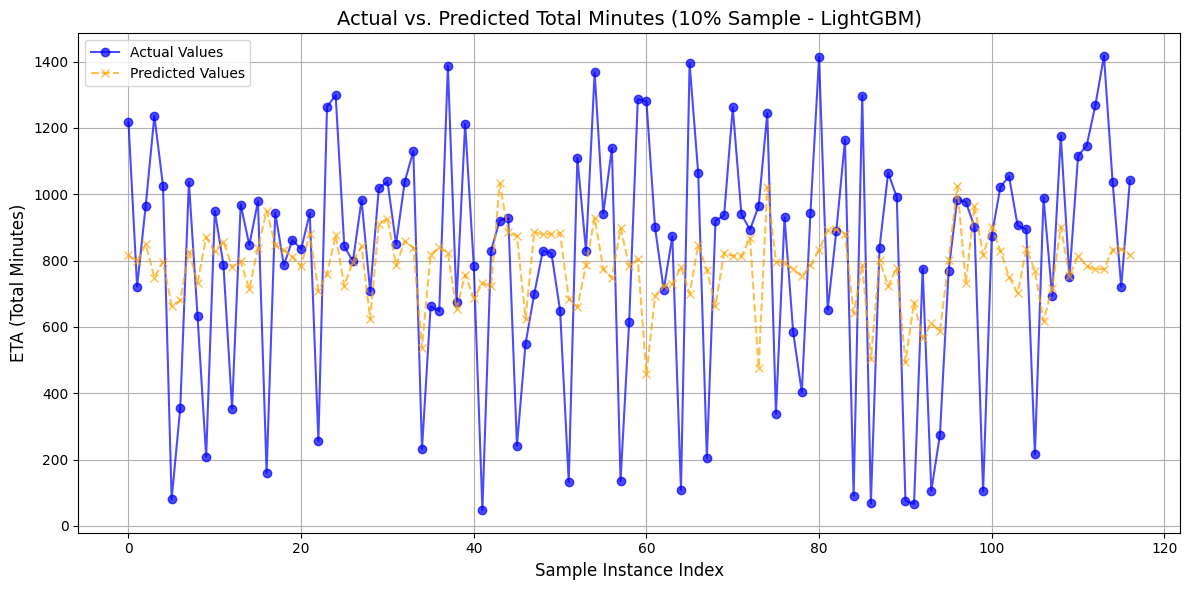

In [14]:
# Assuming X_train_scaled, X_test_scaled, y_train, y_test, and y_test_pred are already defined

# Ensure y_test and y_test_pred are 1-dimensional
y_test = np.ravel(y_test)  # Flatten y_test (if it's 2D)
y_test_pred = np.ravel(y_test_pred)  # Flatten predictions from the LightGBM model

# Step 6: Combine actual and predicted values for plotting
actual_values = pd.Series(y_test)  # Convert to pandas Series
predicted_values = pd.Series(y_test_pred)  # Convert to pandas Series

# Reset indices for alignment
actual_values = actual_values.reset_index(drop=True)
predicted_values = predicted_values.reset_index(drop=True)

# Select 10% of the data for plotting
sample_size = int(len(actual_values) * 0.1)  # 10% of the data
sample_indices = np.random.choice(actual_values.index, size=sample_size, replace=False)  # Random sampling
actual_sample = actual_values.loc[sample_indices]  # Sample actual values
predicted_sample = predicted_values.loc[sample_indices]  # Sample predicted values

# Step 7: Plot line chart for 10% of the data
plt.figure(figsize=(12, 6))
plt.plot(range(len(actual_sample)), actual_sample, label="Actual Values", color="blue", linestyle='-', marker='o', alpha=0.7)
plt.plot(range(len(predicted_sample)), predicted_sample, label="Predicted Values", color="orange", linestyle='--', marker='x', alpha=0.7)

# Customization
plt.title('Actual vs. Predicted Total Minutes (10% Sample - LightGBM)', fontsize=14)
plt.xlabel('Sample Instance Index', fontsize=12)
plt.ylabel('ETA (Total Minutes)', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True)
plt.tight_layout()

# Display the plot
plt.show()
